In [ ]:
%cd '/content/drive/My Drive/CS 415 Project'

/content/drive/.shortcut-targets-by-id/1vr_n2c2jn4NS6hWYwfSFpVQv7RAcwhSK/CS 415 Project


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import random
import shutil

In [ ]:
import tensorflow as tf
import tensorflow.keras as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import load_model, Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Preprocessing Dataset

In [ ]:
img_h = 224
img_w = 224

In [ ]:
def create_df_with_validation(dataset_dir, classes):
    image_paths = []
    labels = []

    for cls in classes:
        cls_dir = os.path.join(dataset_dir, cls)
        for img_file in os.listdir(cls_dir):
            if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(cls_dir, img_file))
                labels.append(cls)

    df = pd.DataFrame({'filename': image_paths, 'class': labels})
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['class'])
    train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42, stratify=train_df['class'])  # 0.25 x 0.8 = 0.2
    return train_df, val_df, test_df

covid_classes = ['Viral Pneumonia', 'Normal', 'Lung_Opacity', 'COVID']
train_df_covid, val_df_covid, test_df_covid = create_df_with_validation("Filtered_COVID_Dataset_7000", covid_classes)

# mnist_classes = ['HeadCT', 'AbdomenCT', 'BreastMRI', 'ChestCT', 'CXR', 'Hand']
# train_df_mnist, val_df_mnist, test_df_mnist = create_df_with_validation("Filtered_Medical_MNIST_7000", mnist_classes)

In [ ]:
def create_generators(train_df, val_df, test_df, img_height = 224, img_width = 224, batch_size=16):
    img_height = img_h
    img_width = img_w
    datagen_train = ImageDataGenerator(rescale=1.0/255)
    datagen_val_test = ImageDataGenerator(rescale=1.0/255)

    train_generator = datagen_train.flow_from_dataframe(
        train_df,
        x_col='filename',
        y_col='class',
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        # class_mode='sparse',
        shuffle=True
    )

    val_generator = datagen_val_test.flow_from_dataframe(
        val_df,
        x_col='filename',
        y_col='class',
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    test_generator = datagen_val_test.flow_from_dataframe(
        test_df,
        x_col='filename',
        y_col='class',
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator, val_generator, test_generator

covid_train_generator, covid_val_generator, covid_test_generator = create_generators(
    train_df_covid, val_df_covid, test_df_covid)

# mnist_train_generator, mnist_val_generator, mnist_test_generator = create_generators(
#     train_df_mnist, val_df_mnist, test_df_mnist)


Found 3957 validated image filenames belonging to 4 classes.
Found 1319 validated image filenames belonging to 4 classes.
Found 1319 validated image filenames belonging to 4 classes.


In [ ]:
def print_dataset_summary(generator, name):
    print(f"Dataset: {name}")
    print(f" - Classes: {generator.class_indices}")
    print(f" - Total samples: {generator.n}")

print_dataset_summary(covid_train_generator, "COVID Training")
# print_dataset_summary(mnist_train_generator, "MNIST Training")

Dataset: COVID Training
 - Classes: {'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}
 - Total samples: 3957


In [ ]:
def compute_weights(train_df, class_labels):
    train_df['class_idx'] = train_df['class'].map({cls: idx for idx, cls in enumerate(class_labels)})
    weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_df['class_idx']),
        y=train_df['class_idx']
    )
    return dict(enumerate(weights))

covid_weights = compute_weights(train_df_covid, covid_classes)
# mnist_weights = compute_weights(train_df_mnist, mnist_classes)


# for batch in covid_train_generator:
#     print("Batch input shape:", batch[0].shape)  # Should be (batch_size, img_height, img_width, 3)
#     print("Batch labels shape:", batch[1].shape)  # Should be (batch_size, num_classes)
#     break

# for batch in covid_train_generator:
#     print(type(batch))  # Check if it's a tuple or a list
#     print(len(batch))   # Check the number of elements yielded
#     break
print("Class weights:", covid_weights)

Class weights: {0: 1.2258364312267658, 1: 0.9421428571428572, 2: 0.9421428571428572, 3: 0.9421428571428572}


# RESNET-50 with Sequential

In [ ]:
# Define the model
def build_resnet_model(input_shape=(img_h, img_w, 3), num_classes=4):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)


    for layer in base_model.layers[:143]:
        layer.trainable = False
    # base_model.trainable = False  # Freeze the base model for transfer learning
    # for i, layer in enumerate(base_model.layers):
    #     print(i, layer.name, "-", layer.trainable)
    # to_res = (224, 224)
    # model = Sequential()
    # model.add(K.layers.Lambda(lambda image: tf.image.resize(image, to_res)))
    # model.add(base_model)
    # model.add(K.layers.Flatten())
    # model.add(K.layers.BatchNormalization())
    # model.add(K.layers.Dense(256, activation='relu'))
    # model.add(K.layers.Dropout(0.5))
    # model.add(K.layers.BatchNormalization())
    # model.add(K.layers.Dense(128, activation='relu'))
    # model.add(K.layers.Dropout(0.5))
    # model.add(K.layers.BatchNormalization())
    # model.add(K.layers.Dense(64, activation='relu'))
    # model.add(K.layers.Dropout(0.5))
    # model.add(K.layers.BatchNormalization())
    # model.add(K.layers.Dense(4, activation='softmax'))


    # x = base_model.output
    # x = GlobalAveragePooling2D()(x)
    # x = Dense(256, activation='relu')(x)
    # x = Dropout(0.5)(x)
    # x = Dense(num_classes, activation='softmax')(x)  # Output layer

    # # model = Model(inputs=base_model.input, outputs=x)
    model = Sequential([base_model, GlobalAveragePooling2D(),  # Global pooling instead of a fully connected layer
    Dense(128, activation="relu"),  # Add a dense layer
    Dropout(0.2),  # Dropout for regularization
    Dense(4, activation="softmax")  # Adjust the output layer to the number of classes
    ])
    # base_model.trainable=True
    return model

# Initialize model
model = build_resnet_model()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
# check_point = K.callbacks.ModelCheckpoint(filepath = "",monitor="val_acc", mode="max",save_best_only=True,)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# model.compile(loss='categorical_crossentropy', optimizer=K.optimizers.RMSprop(learning_rate=2e-5), metrics=['accuracy'])


In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, verbose=1)

history = model.fit(covid_train_generator,
                    batch_size=16, epochs=5, verbose=1,
                    validation_data=covid_val_generator,
                    class_weight = covid_weights,
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/5
248/248 ━━━━━━━━━━━━━━━━━━━━ 2604s 10s/step - accuracy: 0.4037 - loss: 1.3548 - val_accuracy: 0.2039 - val_loss: 113.4240 - learning_rate: 0.0010
Epoch 2/5
248/248 ━━━━━━━━━━━━━━━━━━━━ 38s 149ms/step - accuracy: 0.4882 - loss: 1.0531 - val_accuracy: 0.3381 - val_loss: 3.3653 - learning_rate: 0.0010
Epoch 3/5
248/248 ━━━━━━━━━━━━━━━━━━━━ 35s 139ms/step - accuracy: 0.5734 - loss: 0.9581 - val_accuracy: 0.2434 - val_loss: 9.0977 - learning_rate: 0.0010
Epoch 4/5
248/248 ━━━━━━━━━━━━━━━━━━━━ 43s 148ms/step - accuracy: 0.5867 - loss: 0.9321 - val_accuracy: 0.2055 - val_loss: 10.1884 - learning_rate: 0.0010
Epoch 5/5
248/248 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.6019 - loss: 0.9213
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
248/248 ━━━━━━━━━━━━━━━━━━━━ 38s 136ms/step - accuracy: 0.6019 - loss: 0.9212 - val_accuracy: 0.2047 - val_loss: 25.4961 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 2.


In [ ]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(covid_test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# RESNET **2**

In [ ]:
# Define the model
def build_resnet_model(input_shape=(img_h, img_w, 3), num_classes=4):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)


    # for layer in base_model.layers[:143]:
    #     layer.trainable = False
    base_model.trainable = False  # Freeze the base model for transfer learning
    # for i, layer in enumerate(base_model.layers):
    #     print(i, layer.name, "-", layer.trainable)
    # to_res = (224, 224)
    # model = Sequential()
    # model.add(K.layers.Lambda(lambda image: tf.image.resize(image, to_res)))
    # model.add(base_model)
    # model.add(K.layers.Flatten())
    # model.add(K.layers.BatchNormalization())
    # model.add(K.layers.Dense(256, activation='relu'))
    # model.add(K.layers.Dropout(0.5))
    # model.add(K.layers.BatchNormalization())
    # model.add(K.layers.Dense(128, activation='relu'))
    # model.add(K.layers.Dropout(0.5))
    # model.add(K.layers.BatchNormalization())
    # model.add(K.layers.Dense(64, activation='relu'))
    # model.add(K.layers.Dropout(0.5))
    # model.add(K.layers.BatchNormalization())
    # model.add(K.layers.Dense(4, activation='softmax'))


    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(num_classes, activation='softmax')(x)  # Output layer

    model = Model(inputs=base_model.input, outputs=x)
    # model = Sequential([base_model, GlobalAveragePooling2D(),  # Global pooling instead of a fully connected layer
    # Dense(128, activation="relu"),  # Add a dense layer
    # # Dropout(0.2),  # Dropout for regularization
    # Dense(4, activation="softmax")  # Adjust the output layer to the number of classes
    # ])
    base_model.trainable=True
    return model

# Initialize model
model = build_resnet_model()

### with adam

In [ ]:
# check_point = K.callbacks.ModelCheckpoint(filepath = "",monitor="val_acc", mode="max",save_best_only=True,)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# model.compile(loss='categorical_crossentropy', optimizer=K.optimizers.RMSprop(learning_rate=2e-5), metrics=['accuracy'])


#### 5 EPOCHS

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, verbose=1)

history = model.fit(covid_train_generator,
                    batch_size=16, epochs=5, verbose=1,
                    validation_data=covid_val_generator,
                    class_weight = covid_weights,
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


246/246 ━━━━━━━━━━━━━━━━━━━━ 4231s 17s/step - accuracy: 0.7072 - loss: 0.8875 - val_accuracy: 0.2718 - val_loss: 2.0927 - learning_rate: 0.0010
Epoch 2/5
246/246 ━━━━━━━━━━━━━━━━━━━━ 50s 198ms/step - accuracy: 0.8386 - loss: 0.4554 - val_accuracy: 0.2672 - val_loss: 2.5197 - learning_rate: 0.0010
Epoch 3/5
246/246 ━━━━━━━━━━━━━━━━━━━━ 48s 194ms/step - accuracy: 0.8808 - loss: 0.3335 - val_accuracy: 0.2634 - val_loss: 3.8557 - learning_rate: 0.0010
Epoch 4/5
246/246 ━━━━━━━━━━━━━━━━━━━━ 50s 200ms/step - accuracy: 0.8967 - loss: 0.2648 - val_accuracy: 0.6435 - val_loss: 0.9945 - learning_rate: 0.0010
Epoch 5/5
246/246 ━━━━━━━━━━━━━━━━━━━━ 50s 200ms/step - accuracy: 0.9130 - loss: 0.2420 - val_accuracy: 0.4718 - val_loss: 1.8825 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 4.


### 11 EPOCHS

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, verbose=1)

history = model.fit(covid_train_generator,
                    batch_size=16, epochs=11, verbose=1,
                    validation_data=covid_val_generator,
                    class_weight = covid_weights,
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/11


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


247/247 ━━━━━━━━━━━━━━━━━━━━ 254s 681ms/step - accuracy: 0.6852 - loss: 0.9172 - val_accuracy: 0.2662 - val_loss: 2.0886 - learning_rate: 0.0010
Epoch 2/11
247/247 ━━━━━━━━━━━━━━━━━━━━ 51s 202ms/step - accuracy: 0.8247 - loss: 0.4787 - val_accuracy: 0.2046 - val_loss: 12.4999 - learning_rate: 0.0010
Epoch 3/11
247/247 ━━━━━━━━━━━━━━━━━━━━ 52s 206ms/step - accuracy: 0.8639 - loss: 0.3738 - val_accuracy: 0.3262 - val_loss: 4.1076 - learning_rate: 0.0010
Epoch 4/11
247/247 ━━━━━━━━━━━━━━━━━━━━ 82s 206ms/step - accuracy: 0.8680 - loss: 0.3558 - val_accuracy: 0.7544 - val_loss: 0.5852 - learning_rate: 0.0010
Epoch 5/11
247/247 ━━━━━━━━━━━━━━━━━━━━ 80s 198ms/step - accuracy: 0.9102 - loss: 0.2602 - val_accuracy: 0.8297 - val_loss: 0.4501 - learning_rate: 0.0010
Epoch 6/11
247/247 ━━━━━━━━━━━━━━━━━━━━ 50s 200ms/step - accuracy: 0.9115 - loss: 0.2247 - val_accuracy: 0.7741 - val_loss: 0.7916 - learning_rate: 0.0010
Epoch 7/11
247/247 ━━━━━━━━━━━━━━━━━━━━ 52s 206ms/step - accuracy: 0.9255 - los

In [ ]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(covid_test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

83/83 ━━━━━━━━━━━━━━━━━━━━ 694s 8s/step - accuracy: 0.8911 - loss: 0.3405
Test Loss: 0.34960320591926575, Test Accuracy: 0.8897338509559631


In [ ]:
!pip install pyyaml h5py

In [ ]:
model.save('./resnet-97ac.keras')

## With nadam

In [ ]:
from keras.optimizers import Nadam

# Compile the model with Nadam
model.compile(
    optimizer=Nadam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, verbose=1)

history = model.fit(covid_train_generator,
                    batch_size=16, epochs=11, verbose=1,
                    validation_data=covid_val_generator,
                    class_weight = covid_weights,
                    callbacks=[early_stopping, reduce_lr])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(covid_test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Epoch 1/11


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


248/248 ━━━━━━━━━━━━━━━━━━━━ 371s 1s/step - accuracy: 0.6991 - loss: 0.8481 - val_accuracy: 0.2654 - val_loss: 12.6926 - learning_rate: 0.0010
Epoch 2/11
248/248 ━━━━━━━━━━━━━━━━━━━━ 52s 205ms/step - accuracy: 0.8431 - loss: 0.4333 - val_accuracy: 0.2691 - val_loss: 3.3831 - learning_rate: 0.0010
Epoch 3/11
248/248 ━━━━━━━━━━━━━━━━━━━━ 49s 193ms/step - accuracy: 0.8953 - loss: 0.2956 - val_accuracy: 0.4936 - val_loss: 1.1462 - learning_rate: 0.0010
Epoch 4/11
248/248 ━━━━━━━━━━━━━━━━━━━━ 83s 196ms/step - accuracy: 0.9146 - loss: 0.2546 - val_accuracy: 0.7233 - val_loss: 0.7329 - learning_rate: 0.0010
Epoch 5/11
248/248 ━━━━━━━━━━━━━━━━━━━━ 53s 210ms/step - accuracy: 0.9169 - loss: 0.2433 - val_accuracy: 0.7089 - val_loss: 0.7428 - learning_rate: 0.0010
Epoch 6/11
248/248 ━━━━━━━━━━━━━━━━━━━━ 50s 198ms/step - accuracy: 0.9210 - loss: 0.2269 - val_accuracy: 0.7331 - val_loss: 0.7759 - learning_rate: 0.0010
Epoch 7/11
248/248 ━━━━━━━━━━━━━━━━━━━━ 82s 198ms/step - accuracy: 0.9347 - loss: 

In [ ]:
model.save("./nadam-95.keras")

### 3rd model no

In [ ]:
# Define the model
def build_resnet_model(input_shape=(img_h, img_w, 3), num_classes=4):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)


    # for layer in base_model.layers[:143]:
    #     layer.trainable = False
    base_model.trainable = False  # Freeze the base model for transfer learning

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    # x = Dropout(0.2)(x)
    x = Dense(num_classes, activation='softmax')(x)  # Output layer

    model = Model(inputs=base_model.input, outputs=x)
    # model = Sequential([base_model, GlobalAveragePooling2D(),  # Global pooling instead of a fully connected layer
    # Dense(128, activation="relu"),  # Add a dense layer
    # # Dropout(0.2),  # Dropout for regularization
    # Dense(4, activation="softmax")  # Adjust the output layer to the number of classes
    # ])
    base_model.trainable=True
    return model

# Initialize model
model3 = build_resnet_model()

In [ ]:
# check_point = K.callbacks.ModelCheckpoint(filepath = "",monitor="val_acc", mode="max",save_best_only=True,)
model3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, verbose=1)

history = model3.fit(covid_train_generator,
                    batch_size=16, epochs=11, verbose=1,
                    validation_data=covid_val_generator,
                    class_weight = covid_weights,
                    callbacks=[early_stopping, reduce_lr])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(covid_test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Epoch 1/11
247/247 ━━━━━━━━━━━━━━━━━━━━ 133s 313ms/step - accuracy: 0.6996 - loss: 0.8837 - val_accuracy: 0.2662 - val_loss: 1.8474 - learning_rate: 0.0010
Epoch 2/11
247/247 ━━━━━━━━━━━━━━━━━━━━ 52s 209ms/step - accuracy: 0.8491 - loss: 0.4149 - val_accuracy: 0.2662 - val_loss: 7.5870 - learning_rate: 0.0010
Epoch 3/11
247/247 ━━━━━━━━━━━━━━━━━━━━ 52s 207ms/step - accuracy: 0.8863 - loss: 0.3002 - val_accuracy: 0.2380 - val_loss: 4.1604 - learning_rate: 0.0010
Epoch 4/11
247/247 ━━━━━━━━━━━━━━━━━━━━ 52s 208ms/step - accuracy: 0.8845 - loss: 0.2966 - val_accuracy: 0.7376 - val_loss: 0.6240 - learning_rate: 0.0010
Epoch 5/11
247/247 ━━━━━━━━━━━━━━━━━━━━ 79s 197ms/step - accuracy: 0.9079 - loss: 0.2362 - val_accuracy: 0.4091 - val_loss: 1.3833 - learning_rate: 0.0010
Epoch 6/11
247/247 ━━━━━━━━━━━━━━━━━━━━ 82s 198ms/step - accuracy: 0.9193 - loss: 0.2119 - val_accuracy: 0.5262 - val_loss: 1.3955 - learning_rate: 0.0010
Epoch 7/11
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.9

In [ ]:
model.save('./shit-88ac.keras')

# Model 4 with l2

In [ ]:
# Define the model
def build_resnet_model(input_shape=(img_h, img_w, 3), num_classes=4):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)


    # for layer in base_model.layers[:143]:
    #     layer.trainable = False
    base_model.trainable = False  # Freeze the base model for transfer learning
    # for i, layer in enumerate(base_model.layers):
    #     print(i, layer.name, "-", layer.trainable)


    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu',  kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.2)(x)
    x = Dense(num_classes, activation='softmax')(x)  # Output layer

    model = Model(inputs=base_model.input, outputs=x)

    base_model.trainable=True
    return model

# Initialize model
model4 = build_resnet_model()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# check_point = K.callbacks.ModelCheckpoint(filepath = "",monitor="val_acc", mode="max",save_best_only=True,)
model4.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, verbose=1)

history = model4.fit(covid_train_generator,
                    batch_size=16, epochs=11, verbose=1,
                    validation_data=covid_val_generator,
                    class_weight = covid_weights,
                    callbacks=[early_stopping, reduce_lr])


Epoch 1/11


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


213/213 ━━━━━━━━━━━━━━━━━━━━ 1558s 7s/step - accuracy: 0.6745 - loss: 2.5620 - val_accuracy: 0.3066 - val_loss: 8.9073 - learning_rate: 0.0010
Epoch 2/11
213/213 ━━━━━━━━━━━━━━━━━━━━ 43s 199ms/step - accuracy: 0.8148 - loss: 0.8268 - val_accuracy: 0.2282 - val_loss: 2.2262 - learning_rate: 0.0010
Epoch 3/11
213/213 ━━━━━━━━━━━━━━━━━━━━ 81s 194ms/step - accuracy: 0.8615 - loss: 0.5052 - val_accuracy: 0.2282 - val_loss: 3.3744 - learning_rate: 0.0010
Epoch 4/11
213/213 ━━━━━━━━━━━━━━━━━━━━ 46s 215ms/step - accuracy: 0.8873 - loss: 0.4198 - val_accuracy: 0.5163 - val_loss: 1.4288 - learning_rate: 0.0010
Epoch 5/11
213/213 ━━━━━━━━━━━━━━━━━━━━ 79s 200ms/step - accuracy: 0.9086 - loss: 0.3257 - val_accuracy: 0.8502 - val_loss: 0.4650 - learning_rate: 0.0010
Epoch 6/11
213/213 ━━━━━━━━━━━━━━━━━━━━ 82s 198ms/step - accuracy: 0.9233 - loss: 0.2689 - val_accuracy: 0.4185 - val_loss: 4.4264 - learning_rate: 0.0010
Epoch 7/11
213/213 ━━━━━━━━━━━━━━━━━━━━ 44s 203ms/step - accuracy: 0.9295 - loss: 

In [ ]:

# Evaluate the model
test_loss, test_accuracy = model4.evaluate(covid_test_generator)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

71/71 ━━━━━━━━━━━━━━━━━━━━ 349s 5s/step - accuracy: 0.8535 - loss: 0.4569
Test Loss: 0.4681612551212311, Test Accuracy: 0.8528634309768677


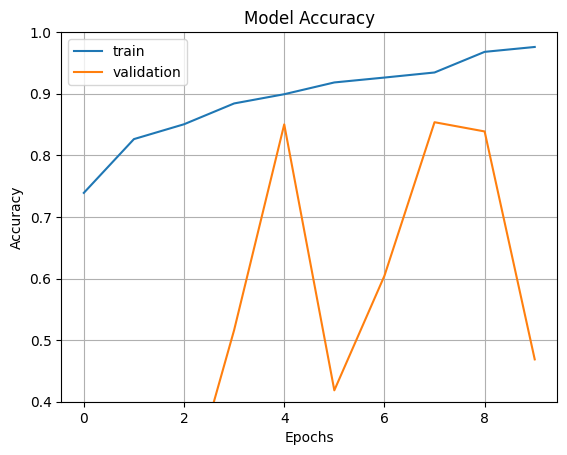

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate the ResNet-50 model
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4, ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

## discard below

In [ ]:
# check_point = K.callbacks.ModelCheckpoint(filepath = "",monitor="val_acc", mode="max",save_best_only=True,)
model4.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, verbose=1)

history = model4.fit(covid_train_generator,
                    batch_size=16, epochs=11, verbose=1,
                    validation_data=covid_val_generator,
                    class_weight = covid_weights,
                    callbacks=[early_stopping, reduce_lr])


Epoch 1/11


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


248/248 ━━━━━━━━━━━━━━━━━━━━ 1674s 6s/step - accuracy: 0.6877 - loss: 2.4114 - val_accuracy: 0.2654 - val_loss: 1.7610 - learning_rate: 0.0010
Epoch 2/11
248/248 ━━━━━━━━━━━━━━━━━━━━ 105s 191ms/step - accuracy: 0.8227 - loss: 0.7043 - val_accuracy: 0.2654 - val_loss: 2.5450 - learning_rate: 0.0010
Epoch 3/11
248/248 ━━━━━━━━━━━━━━━━━━━━ 49s 195ms/step - accuracy: 0.8687 - loss: 0.4445 - val_accuracy: 0.2737 - val_loss: 3.3699 - learning_rate: 0.0010
Epoch 4/11
248/248 ━━━━━━━━━━━━━━━━━━━━ 48s 191ms/step - accuracy: 0.8962 - loss: 0.3376 - val_accuracy: 0.7559 - val_loss: 0.7282 - learning_rate: 0.0010
Epoch 5/11
248/248 ━━━━━━━━━━━━━━━━━━━━ 51s 203ms/step - accuracy: 0.9067 - loss: 0.3123 - val_accuracy: 0.5701 - val_loss: 1.3237 - learning_rate: 0.0010
Epoch 6/11
248/248 ━━━━━━━━━━━━━━━━━━━━ 48s 193ms/step - accuracy: 0.9203 - loss: 0.2738 - val_accuracy: 0.6384 - val_loss: 1.0611 - learning_rate: 0.0010
Epoch 7/11
248/248 ━━━━━━━━━━━━━━━━━━━━ 48s 192ms/step - accuracy: 0.9332 - loss:

NameError: name 'model' is not defined